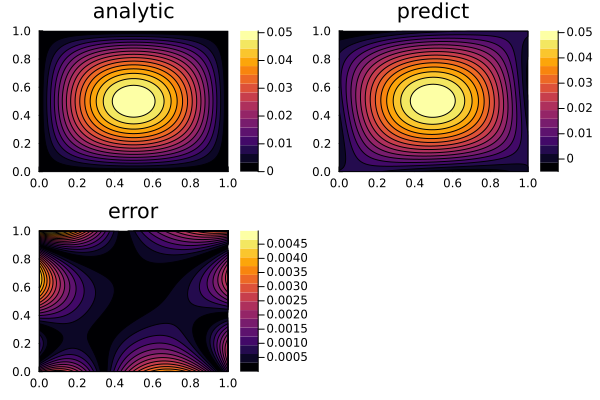

In [2]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL, LineSearches, Plots
using ModelingToolkit: Interval

@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

# 2D PDE
eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ -sin(pi * x) * sin(pi * y)

# Boundary conditions
bcs = [
    u(0, y) ~ 0.0, u(1, y) ~ 0.0,
    u(x, 0) ~ 0.0, u(x, 1) ~ 0.0
]
# Space and time domains
domains = [x ∈ Interval(0.0, 1.0), y ∈ Interval(0.0, 1.0)]

# Neural network
dim = 2 # number of dimensions
chain = Chain(Dense(dim, 16, σ), Dense(16, 16, σ), Dense(16, 1))

# Discretization
discretization = PhysicsInformedNN(
    chain, QuadratureTraining(; batch = 200, abstol = 1e-6, reltol = 1e-6))

@named pde_system = PDESystem(eq, bcs, domains, [x, y], [u(x, y)])
prob = discretize(pde_system, discretization)

#Callback function
callback = function (p, l)
    println("Current loss is: $l")
    return false
end

# Optimizer
opt = LBFGS(linesearch = BackTracking())
res = solve(prob, opt, maxiters = 1000)
phi = discretization.phi

dx = 0.05
xs, ys = [infimum(d.domain):(dx / 10):supremum(d.domain) for d in domains]
analytic_sol_func(x, y) = (sin(pi * x) * sin(pi * y)) / (2pi^2)

u_predict = reshape([first(phi([x, y], res.u)) for x in xs for y in ys],
    (length(xs), length(ys)))
u_real = reshape([analytic_sol_func(x, y) for x in xs for y in ys],
    (length(xs), length(ys)))
diff_u = abs.(u_predict .- u_real)

p1 = plot(xs, ys, u_real, linetype = :contourf, title = "analytic");
p2 = plot(xs, ys, u_predict, linetype = :contourf, title = "predict");
p3 = plot(xs, ys, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)

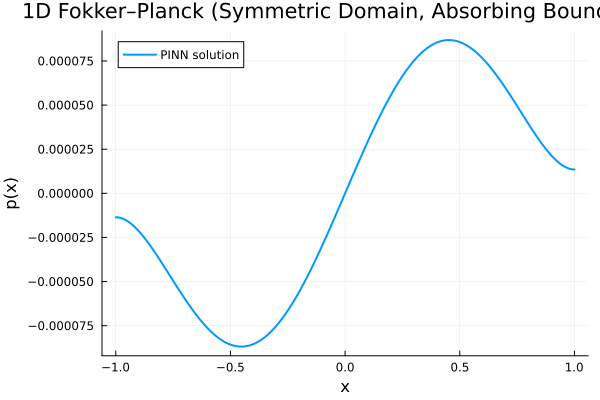

In [4]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL, LineSearches, Plots
using ModelingToolkit: Interval, Differential

@parameters x
@variables p(..)

# Drift and diffusion functions
f(x) = -x         # symmetric drift toward center
D(x) = 0.1        # constant diffusion

∂x = Differential(x)

# Fokker–Planck steady-state PDE
drift_term = ∂x(f(x) * p(x))            # -∂x[f(x)p(x)]
diff_term  = ∂x(∂x(D(x) * p(x)))        # ∂xx[D(x)p(x)]
eq = -drift_term + diff_term ~ 0.0

# Absorbing boundary conditions at symmetric ends
bcs = [
    p(-1.0) ~ 0.0,
    p( 1.0) ~ 0.0
]

# Symmetric domain
domain = [x ∈ Interval(-1.0, 1.0)]

# Lux-compatible neural network
chain = Chain(
    Dense(1 => 32, tanh),
    Dense(32 => 32, tanh),
    Dense(32 => 1)
)

discretization = PhysicsInformedNN(
    chain, QuadratureTraining(batch=100, abstol=1e-6, reltol=1e-6)
)

@named pde_system = PDESystem(eq, bcs, domain, [x], [p(x)])
prob = discretize(pde_system, discretization)

# Train with BFGS optimizer
opt = LBFGS(linesearch = BackTracking())
res = solve(prob, opt; maxiters=1000)

# Plot result
phi = discretization.phi
xs = range(-1.0, 1.0; length=200)
ps = [phi([xv], res.u)[1] for xv in xs]

plot(xs, ps, xlabel="x", ylabel="p(x)", lw=2, label="PINN solution",
     title="1D Fokker–Planck (Symmetric Domain, Absorbing Boundaries)")


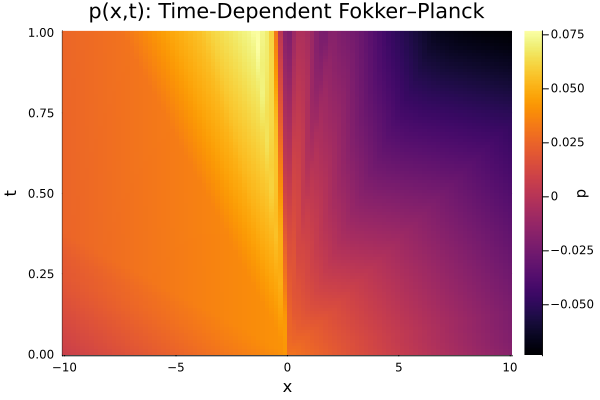

In [29]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL, LineSearches, Plots
using ModelingToolkit: Interval, Differential

# 1. Variables
@parameters x t
@variables p(..)
∂x = Differential(x)
∂t = Differential(t)

# 2. Drift and diffusion
f(x) = -x         # drift toward center
D(x) = 0.001        # constant diffusion

# 3. Fokker–Planck equation
eq = ∂t(p(x, t)) ~ -∂x(f(x) * p(x, t)) + ∂x(∂x(D(x) * p(x, t)))

# 4. Domains
domains = [
    x ∈ Interval(-10.0, 10.0),
    t ∈ Interval(0.0, 1.0)
]

# 5. Initial condition: narrow Gaussian
ε = 0.05
p₀(x) = exp(-x^2 / ε)

# 6. Absorbing BCs + initial condition
#bcs = [
#    p(x, 0.0) ~ p₀(x),
#    p(-1.0, t) ~ 0.0,
#    p(1.0, t) ~ 0.0
#]

bcs = [
    p(x, 0.0) ~ p₀(x)  # initial condition only
]

@named pde_system = PDESystem(eq, bcs, domains, [x, t], [p(x, t)])

# 7. Lux neural network (typed, 2D input → 1 output)
Lux.Chain(
    Lux.Dense(2 => 64, tanh),
    Lux.Dense(64 => 64, tanh),
    Lux.Dense(64 => 1),
    x -> softplus.(x)  # ensures output is ≥ 0
)

# 8. Discretization
discretization = PhysicsInformedNN(
    chain,
    QuadratureTraining(batch=200)
)

# 9. Create and solve optimization problem
prob = discretize(pde_system, discretization)
opt = LBFGS(linesearch = BackTracking())
res = solve(prob, opt; maxiters=1000)

# 10. Plot heatmap of p(x, t)
phi = discretization.phi
xs = range(-10.0, 10.0; length=100)
ts = range(0.0, 1.0; length=102)
u_vals = [phi([xv, tv], res.u)[1] for xv in xs, tv in ts]

heatmap(xs, ts, u_vals', xlabel="x", ylabel="t",
        title="p(x,t): Time-Dependent Fokker–Planck",
        colorbar_title="p")


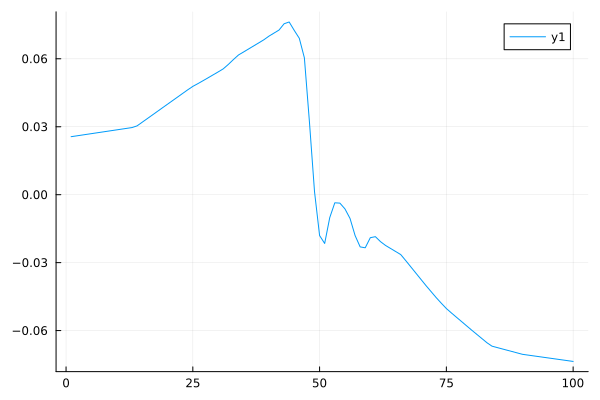

In [31]:
plot(u_vals[:,102])

In [38]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL, LineSearches
using Integrals, Cubature
using ModelingToolkit: Interval, infimum, supremum

@parameters x
@variables p(..)
Dx = Differential(x)
Dxx = Differential(x)^2

α = -0.5
_σ = 0.5
x_0 = -2.2
x_end = 2.2

eq = Dx((α * x) * p(x)) ~ (_σ^2 / 2) * Dxx(p(x))

# Initial and boundary conditions
bcs = [p(x_0) ~ 0.0, p(x_end) ~ 0.0]

# Space and time domains
domains = [x ∈ Interval(x_0, x_end)]

# Neural network
inn = 18
chain = Lux.Chain(Dense(1, inn, Lux.σ),
    Dense(inn, inn, Lux.σ),
    Dense(inn, inn, Lux.σ),
    Dense(inn, 1))

lb = [x_0]
ub = [x_end]
function norm_loss_function(phi, θ, p)
    function inner_f(x, θ)
        0.01 * phi(x, θ) .- 1
    end
    prob = IntegralProblem(inner_f, lb, ub, θ)
    norm2 = solve(prob, HCubatureJL(), reltol = 1e-8, abstol = 1e-8, maxiters = 10)
    abs(norm2[1])
end

discretization = PhysicsInformedNN(chain,
    QuadratureTraining(),
    additional_loss = norm_loss_function)

@named pdesystem = PDESystem(eq, bcs, domains, [x], [p(x)])
prob = discretize(pdesystem, discretization)
phi = discretization.phi

sym_prob = NeuralPDE.symbolic_discretize(pdesystem, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions
approx_derivative_loss_functions = sym_prob.loss_functions.bc_loss_functions

cb_ = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    println("additional_loss: ", norm_loss_function(phi, p.u, nothing))
    return false
end

res = Optimization.solve(
    prob, BFGS(linesearch = BackTracking()), callback = cb_, maxiters = 600)

loss: 4.41191167762665
pde_losses: [0.0017318881013398501]
bcs_losses: [0.005697275337791908, 0.008152308164064846]
additional_loss: 4.396330206023453
loss: 4.399896325639014
pde_losses: [4.219754682690963e-5]
bcs_losses: [4.762347042516887e-6, 0.000304119821196689]
additional_loss: 4.399545245923948
loss: 4.399889240575066
pde_losses: [4.119344816523075e-5]
bcs_losses: [5.7123671419726715e-6, 0.0002967993854130032]
additional_loss: 4.399545535374346
loss: 4.399769157821134
pde_losses: [2.360753340635587e-5]
bcs_losses: [8.837642590455514e-5, 0.00010200201475567985]
additional_loss: 4.399555171847068
loss: 4.39976909647004
pde_losses: [2.3744851293198696e-5]
bcs_losses: [9.152953451420648e-5, 9.997846081218444e-5]
additional_loss: 4.39955384362342
loss: 4.399769075761091
pde_losses: [2.377341397413805e-5]
bcs_losses: [9.217243047155619e-5, 9.956929683770715e-5]
additional_loss: 4.3995535606198075
loss: 4.3997689065345975
pde_losses: [2.393237984556998e-5]
bcs_losses: [9.561476245950605

retcode: Failure
u: ComponentVector{Float64}(layer_1 = (weight = [8.149312433759837; 22.151892746409032; … ; -2.1046281381836818; -4.7268465950185075;;], bias = [-16.187744317156298; 1.8381718648623802; … ; 10.101084029324246; -3.274985004218749;;]), layer_2 = (weight = [0.43288880225233684 2.3424088017855813 … 5.391138640648492 3.7285457607795864; -0.774521293693161 3.015644665270097 … 2.673365897912927 2.4906108436470307; … ; -2.076375894389697 0.16127930420561565 … -3.4818733729654854 0.22751241764325877; 1.6143017112717375 -1.1558015872987504 … -2.9976675864672653 2.475315179089386], bias = [6.18051947562761; 1.7202429392060326; … ; -0.7122886484107489; 1.2561179349523557;;]), layer_3 = (weight = [-7.628543367213552 -5.168341228232635 … 4.7222681860532605 -3.5038068222779355; 10.199992632917633 5.33501277054035 … 2.2372871722542333 4.488177975689279; … ; -2.3764381570695083 -5.381861683562706 … 4.859978300772455 -4.008702743550538; 11.597061509977628 7.183137179685055 … -1.31032320

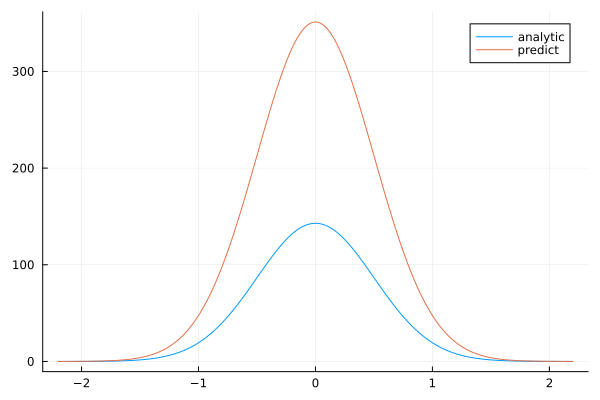

In [39]:
using Plots
C = 142.88418699042 #fitting param
analytic_sol_func(x) = C * exp((1 / (2 * _σ^2)) * (2 * α * x^2))

xs = [infimum(d.domain):0.01:supremum(d.domain) for d in domains][1]
u_real = [analytic_sol_func(x) for x in xs]
u_predict = [first(phi(x, res.u)) for x in xs]

plot(xs, u_real, label = "analytic")
plot!(xs, u_predict, label = "predict")